In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import pandas as pd

from qtrendutils import linfit_utils as linfit
from qtrendutils import colormap_utils as mycolors

from matplotlib.colors import BoundaryNorm
plt.rc('font', family='Arial')

import sys
from matplotlib import colors as c
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/rolling/"

In [4]:
# Observed Trends
era5 = xr.open_dataset(basepath+'vptrends_ERA5_rolling.nc')

w = np.cos(np.deg2rad(era5.lat))
era5w = era5.rolling_era5_trends.weighted(w)
era5m = era5w.mean('z')

In [5]:
# CMIP6 trends
cmip6models = pd.read_csv('/home/islas/python/qtrend_paper/DATA_SORT/CMIP6/cmip6csvinfo.csv')
models = cmip6models['Model']
nmems = cmip6models['Nmem']
nmemmax = np.max(cmip6models['Nmem'])

cmip6datt = []

for index, modname in models.iteritems():
    dat = xr.open_dataset(basepath+'vptrends_rolling_'+modname+'.nc')
    w = np.cos(np.deg2rad(dat.lat))
    datw = dat.rolling_cmip6_trend.weighted(w)
    datm = datw.mean('z')
    cmip6datt.append(datm)

cmip6dat = xr.concat(cmip6datt, dim='model', coords='minimal', compat='override')
cmip6dat = cmip6dat.assign_coords(model=('model',models))

In [6]:
cmip6dat_em = cmip6dat.mean('member', skipna=True)
cmip6dat_modelmean = cmip6dat_em.mean('model')

In [7]:
cmip6dat_stack = cmip6dat.stack(z=('model','member'))
testpoint = cmip6dat_stack.isel(yintrend=0, year=20)
cmip6dat_stack = cmip6dat_stack.where( ~np.isnan(testpoint), drop=True)
mincmip6 = cmip6dat_stack.quantile(0.025, dim='z') ; maxcmip6 = cmip6dat_stack.quantile(0.975, dim='z')

/project/cas02/islas/miniconda3/envs/islaenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [8]:
difsignif = xr.DataArray(np.zeros([cmip6dat.yintrend.size, cmip6dat.year.size])*nan,
                         coords=[cmip6dat.yintrend, cmip6dat.year],
                         dims=['yintrend','year'], name='signif')
difsignif = difsignif.where( (era5m < mincmip6) | (era5m > maxcmip6), 1)

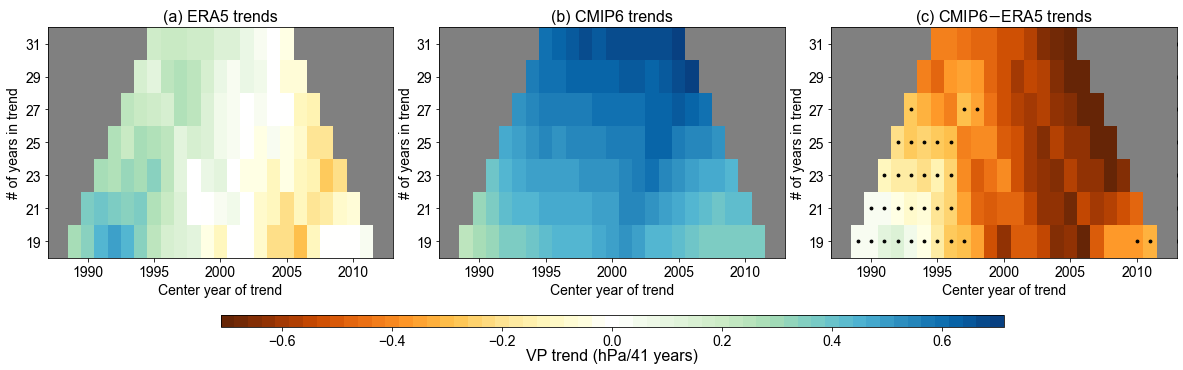

In [9]:
#---Set up the shading for the NaN trends
graymap = c.ListedColormap(['gray'])
nantrends = xr.where(np.isnan(era5m), 1, nan)

fig = plt.figure(figsize=(16,16))

#---------ERA5
ax = fig.add_axes([0.02,0.72,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(a) ERA5 trends', fontsize=16)

cmax=0.7 ; cmin=-0.7 ; ci=0.025
nlevs = (cmax - cmin)/ci + 1
clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( era5m.year, era5m.yintrend, era5m, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

#---------CMIP6
ax = fig.add_axes([0.36,0.72,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(b) CMIP6 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( cmip6dat_modelmean.year, cmip6dat_modelmean.yintrend, cmip6dat_modelmean, cmap=mymap, norm=norm)
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

#---------Difference
ax = fig.add_axes([0.7,0.72,0.3,0.2])
ax.set_xlim(1987,2013)
ax.set_yticks([19,21,23,25,27,29,31])
ax.set_yticklabels(['19','21','23','25','27','29','31'], fontsize=14)
ax.set_xticks([1990,1995,2000,2005,2010])
ax.set_xticklabels(['1990','1995','2000','2005','2010'], fontsize=14)
ax.set_xlabel('Center year of trend', fontsize=14)
ax.set_ylabel('# of years in trend', fontsize=14)
ax.set_title('(c) CMIP6$-$ERA5 trends', fontsize=16)

clevs = np.arange(cmin, cmax+ci, ci)
mymap = mycolors.precip_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=mymap.N, clip=True)

ax.pcolormesh( cmip6dat_modelmean.year, cmip6dat_modelmean.yintrend, era5m - cmip6dat_modelmean, cmap=mymap, norm=norm)


signifdat = difsignif.stack(z=("yintrend","year"))
signifdat = signifdat.dropna('z')
ax.scatter( signifdat.year, signifdat.yintrend, s=8, color='black')
ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

ax.pcolormesh( nantrends.year, nantrends.yintrend, nantrends, cmap=graymap)

ax = cbars.plotcolorbar(fig, ci, cmin, cmax, 'VP trend (hPa/41 years)', 0.17,0.85,0.66,0.67, cmap='precip')

fig.savefig(plotpath+'figS21.pdf', bbox_inches='tight', facecolor='white')